In [187]:
import pandas as pd
import code_base as cb
import matplotlib.pyplot as plt
import numpy as np


# **Group Project** 


## **Introduction** 
- we see the effect of value and momentum factors having postitive effects when combined together
- on their is also wide documentation of "earning announcement effect", where abnormal returns have been found from earning announcements from holding before and after announcement periods 

- this is from,
- rather than the indiviudal day holding we would like to investimage if this would also affect the a stock's factor exposure, 
- we would like to investigate if this would substaintially affect the 

### Creating Factors

In [188]:
# extracting data
df_dict = cb.read_multi_csv(
    filenames=["df_memboolG_spx","df_mcap_spx","df_monthly_spx","df_annsup_spx","df_annest_spx","df_anndat_spx","df_annacc_spx","df_P2BR_spx","df_Beta_spx"],
    name = ["tmbool", "mcap", "price", "annsup", "annest", "anndat", "annacc", "ptbr", "beta"]
)



In [189]:

# shifting regieme by 1 to prevent hindsight bias  
df_dict["annacc"]=df_dict["annacc"].shift(1)
df_dict["annsup"]=df_dict["annsup"].shift(1)

# creating value factor
df_dict["VAL"] = 1/df_dict["ptbr"]

# creating a earnings suprise factor
df_dict["SUP"] =  df_dict["anndat"].shift(1)*df_dict["annsup"]
df_dict["SUP"].ffill(inplace=True)

# creating stock returns 
df_dict["ret"] = (df_dict["price"]/df_dict["price"].shift(1))-1





In [190]:
# calculating momentum factor, the returns from -2 to -10
tdf = pd.DataFrame(df_dict["ret"])
tdf +=1 
tdf = tdf.rolling(10,1).apply(np.prod, raw=True)

df_dict["MOM"] = tdf.shift(2)
df_dict["MOM"] -=1

# # absolute momentum (where we take mean of 0 when calculating, )
df_dict["MOM-A"] = df_dict["MOM"].copy()
# # df_dict["MOM-A"] = df_dict["MOM-A"].divide(df_dict["MOM-A"].std(1,skipna=True), "index")

# size factor
df_dict["CAP"] = df_dict["mcap"]

# earning estimates (EST), actual earnings (ERN)
df_dict["EST"] = df_dict["annest"]

df_dict["EP4"] = cb.past_nvalid_values(df_dict["annest"],4)
ans = (df_dict["annest"].divide(df_dict["EP4"])-1)
ans[ans<-100]=-100
ans[ans>2000]=2000
df_dict["ETG"] = ans
df_dict["ETG"].ffill(inplace=True)


# df_dict["ERN"] = df_dict["annacc"]

# earnings growth factor 
df_dict["AP4"] = cb.past_nvalid_values(df_dict["annacc"],4)
ans = (df_dict["annacc"].divide(df_dict["AP4"])-1)
ans[ans<-100]=-100
ans[ans>2000]=2000
df_dict["ERG"] = ans
df_dict["ERG"].ffill(inplace=True)

out_dict = cb.dict_transfer(df_dict,["ret","VAL","MOM","MOM-A","SUP","ERG","CAP","EST","ETG"])



In [191]:
# generate a "test" set & "training" set
tmbool =  df_dict["tmbool"].copy()
# ratio = 60%
ratio = 0.6
row = int(round((tmbool.shape[0])*ratio,0))
tmbool_train = tmbool.iloc[:row,:]
tmbool_test = tmbool.iloc[row:,:]

In [192]:


# df_dict["ERG"] = df_dict["ERG"].divide(df_dict["ERG"].std(1,skipna=True), "index")
# apply normalisation

data = cb.data_obj(tmbool,out_dict)

data.calc_z_scores(True,["MOM","VAL"])
data.calc_z_scores(True,["MOM-A","ERG","ETG"],False)

# calculate momentum value composite factor  
momval = (data.get("VAL").fillna(0)+data.get("MOM").fillna(0))/2
data.append("MOM_VAL", momval)
data.regulate(["MOM_VAL"])
data.calc_z_scores(inplace=True,fields=["MOM_VAL"])


In [193]:
port = data.to_port("MOM_VAL" ,tmbool=tmbool_train)
port.gen_weights_from_score(0.1)
momval_ret, momval_cret = port.get_port_ret(bps=10)

port_mom = data.to_port("MOM",tmbool=tmbool_train)
port_mom.gen_weights_from_score(0.1)
mom_ret, mom_cret = port_mom.get_port_ret(bps=10)

port_val = data.to_port("VAL",tmbool=tmbool_train)
port_val.gen_weights_from_score(0.1)
mom_ret, val_cret = port_val.get_port_ret(bps=10)


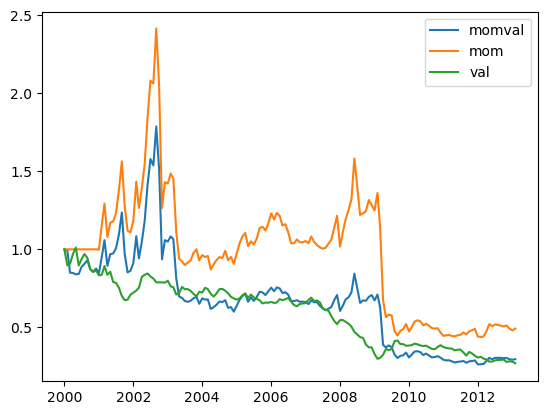

In [194]:
plt.plot(momval_cret)
plt.plot(mom_cret)
plt.plot(val_cret)
plt.legend(["momval","mom","val"])

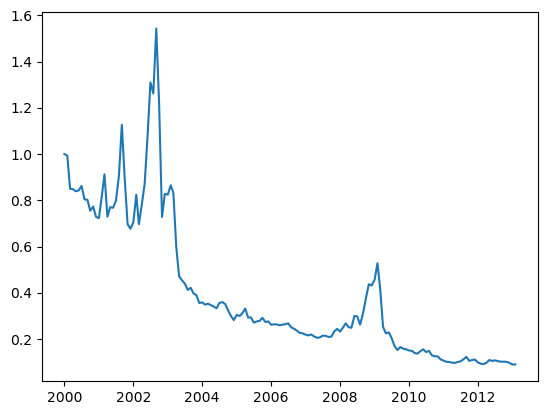

In [195]:
w_ret , w_cret = port_mom.get_port_ret(port.sw,10)
plt.plot(w_cret)


In [212]:
try: 
    data.data_dict.pop("EJC")
except:
    pass 

sup = data.get("SUP")
mom = data.get("MOM-A")
val = data.get("VAL")

mom.fillna(0,inplace = True)
val.fillna(0,inplace = True)
cuttoff = 0.4

fmb = 0.6
fvb = 0.4
fcb = 0.1

fmp = -0.75
fvp = 0.25
fcp = 1

fmn = 0 #0.825
fvn = 1 #0.125
fcn = 0 #-1.75

# basecase 
ejustc = fmb*mom + fvb*val + fcb

# positive
ejustc[sup>=cuttoff] = fmp*mom[sup>=cuttoff] + fvp*val[sup>=cuttoff] + fcp

# neg
cuttoff = 0.4

ejustc[sup<= -cuttoff] = fmn*mom[sup<= -cuttoff] + fvn*val[sup<= -cuttoff] + fcn

data.append("EJC",ejustc)





In [213]:
port_ejc = data.to_port("EJC", tmbool_train)
port_ejc.gen_weights_from_score(0.1)
ejc_ret, ejc_cret= port_ejc.get_port_ret(bps=10)

# lejc_ret, lejc_cret= port_ejc.get_port_ret(port_ejc.sw,bps=10)

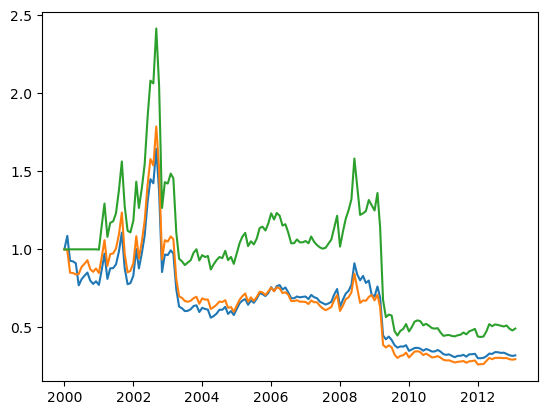

In [210]:
plt.plot(ejc_cret)
plt.plot(momval_cret)
plt.plot(mom_cret)
# plt.plot(lejc_cret)